# Prevendo qualidade de vinho com regressão

## Enunciado

O vinho verde é um produto único da região de Minho, do Noroeste de Portugal. Médio em álcool, este vinho é particularmente apreciado devido ao seu frescor, especialmente no verão. Com base nisso, foram coletadas as seguintes informações sobre o vinho:

1. Acidez fixa (fixed acidity).
2. Acidez critica (critical acidity).
3. Acidez volátil (volatile acidity).
4. Açúcar residual (residual sugar).
5. Concentração de cloretos (chlorides).
6. Concentração de dióxido sulfúrico livre (free sulphur dioxide).
7. Concentração total dióxido sulfúrico (free sulphur dioxide).
8. Densidade (density).
9. pH (pH).
10. Concentração de sulfatos (sulphates).
11. Concentração alcoólica (alcohol).

Output (baseado na avaliação média de especialistas):

12. Qualidade (quality) (score 0-10).

Há dois datasets, relacionados às variantes vermelha e branca do "vinho verde", de Portugal. Escolha um dos datasets contendo informações de uma das variantes (vermelha ou branca) e crie um modelo de regressão para prever a qualidade do vinho. A entrega é individual e deverá ser colocada no github pessoal

## TODOs

- Data Preprocessing
  - ~~Check for missing values~~
  - Handle outliers (necessary?)
- EDA
  - ~~Visualize distributions~~
  - Visualize correlations
  - Visualize feature importance
  - Feature engineering
- Modelling
  - Pipeline
    - ~~normalize/scale features~~
  - ~~Start with simple model (non-tuned)~~
    - ~~XGBoost~~
    - ~~RandomForestRegressor~~
  - ~~Hyperparameter tuning~~
    - ~~Cross validation for parameter optimization~~
  - ~~Evaluation~~
    - ~~Measure performance~~
      - ~~RMSE~~
      - ~~R^2$~~

A. Problem Complexity:
Predicting wine quality based on physicochemical properties is inherently challenging because:

Wine quality is subjective, influenced by expert ratings and sensory factors not captured by the data.

Quality may depend on other external factors (e.g., production method, aging), which are not included in your dataset.

B. Typical Performance in Similar Tasks:
In similar wine quality prediction tasks, achieving an R2 between 0.4 and 0.6 is common.

Even well-tuned models with extensive feature engineering rarely exceed 0.6 to 0.7 in such cases.


## Setup


### Importando pacotes e dados


In [1]:
# Importando pacotes

# Type hinting
from typing import Tuple, List, Dict

# Manipulação de dados
import numpy as np
import pandas as pd

# Visualização
import seaborn as sns
import matplotlib.pyplot as plt

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Utilidades
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

# Métricas
from sklearn.metrics import root_mean_squared_error, r2_score

# Modelo regressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Importando dados
red_wine_df = pd.read_csv('../datasets/winequality/winequality-red.csv', sep=';')
white_wine_df = pd.read_csv('../datasets/winequality/winequality-white.csv', sep=';')

In [3]:
# Head do dataset de vinho branco
red_wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
# Head do dataset de vinho branco
white_wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


### Declaração de funções


In [5]:
# Função para imprimir boxplots dos dados
def dataframe_boxplots(
    df: pd.DataFrame, color_dict: Dict[str, Tuple[float, float, float]]
) -> None:
    _, ax = plt.subplots(nrows=4, ncols=3, figsize=(30, 18))

    axes = ax.flatten()
    for i, column in enumerate(df):
        sns.boxplot(df[column], orient='h', color=color_dict[column], ax=axes[i])
        axes[i].set_title(f'Boxplot {column}')
    plt.suptitle('Features boxplots')
    plt.tight_layout()
    plt.show()

In [6]:
# Função para imprimir histograma dos dados
def dataframe_histograms(
    df: pd.DataFrame, color_dict: Dict[str, Tuple[float, float, float]]
) -> None:
    _, ax = plt.subplots(nrows=4, ncols=3, figsize=(30, 18))

    axes = ax.flatten()
    for i, column in enumerate(df):
        sns.histplot(df[column], color=color_dict[column], ax=axes[i])
        axes[i].set_title(f'Histogram {column}')
    plt.suptitle('Features distributions')
    plt.tight_layout()
    plt.show()

In [7]:
# Função para imprimir visualização de correlação
def plot_correlation(
    corr_df: pd.Series, color_dict: Dict[str, Tuple[float, float, float]]
) -> None:
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=corr_df.values,
        hue=corr_df.index,
        palette='Paired',
    )
    plt.title('Correlation of columns and diabetes diagnose (Outcome)', fontsize=12)
    plt.xlabel('Pearson Correlation')
    plt.ylabel('Columns')
    plt.tight_layout()
    plt.show()

In [8]:
# Função para calcular os limites inferiores e superiores
def upper_lower_limit(
    data: pd.DataFrame, col_name: str, quantile: np.float64 = None
) -> Tuple[np.float64, np.float64]:
    # Retornando determinado quantil
    if quantile:
        return data[col_name].quantile(quantile), data[col_name].quantile(1 - quantile)

    # Calculando quantis
    q1 = data[col_name].quantile(0.25)
    q3 = data[col_name].quantile(0.75)

    # Calculando limites
    upper_whisker = min(q3 + 1.5 * (q3 - q1), data[col_name].max())
    lower_whisker = max(q1 - 1.5 * (q3 - q1), data[col_name].min())

    return upper_whisker, lower_whisker

In [9]:
# Função para calcular quantidade de outliers
def print_num_outliers(
    data: pd.DataFrame, col_name: str, whiskers: Tuple[np.float64, np.float64]
) -> None:
    upper_outliers = (data[col_name] > whiskers[0]).sum()
    lower_outliers = (data[col_name] < whiskers[1]).sum()

    name_text = f'{col_name}\'s outliers:'
    outlier_text = f'{upper_outliers} (upper) | {lower_outliers} (lower) | {upper_outliers + lower_outliers} (total) |'

    print('-' * 80)
    print(name_text, ' ' * (78 - len(name_text + outlier_text)), outlier_text)

In [10]:
# Função para imprimir valores dos limites
def print_whiskers(col_name: str, whiskers: Tuple[np.float64, np.float64]) -> None:
    name_text = f'{col_name}\'s whiskers:'
    outlier_text = f'{whiskers[0]:.2f} (upper) | {whiskers[1]:.2f} (lower) |'

    print('-' * 80)
    print(name_text, ' ' * (78 - len(name_text + outlier_text)), outlier_text)

In [11]:
# Função para remoção de outliers
def remove_outliers(
    df: pd.DataFrame,
    columns: List[str],
    whiskers_dict: Dict[str, Tuple[np.float64, np.float64]],
    remove_upper: bool = True,
    remove_lower: bool = True,
) -> pd.DataFrame:
    mask = pd.Series(True, index=df.index)
    for col in columns:
        upper, lower = whiskers_dict[col]
        col_mask = pd.Series(True, index=df.index)

        if remove_upper:
            col_mask &= df[col] <= upper
        if remove_lower:
            col_mask &= df[col] >= lower

        mask &= col_mask

    return df[mask].copy(deep=True)

In [12]:
# Função para gerar pipeline de XGBRegressor
def xgboost_pipeline() -> Pipeline:
    return Pipeline(
        steps=[
            ('scaler', StandardScaler()),
            ('model', XGBRegressor(random_state=42)),
        ]
    )

## EDA


### Overview dos dados


In [13]:
# Obtendo informações sobre os datasets
red_wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [14]:
# Obtendo informações sobre os datasets
white_wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


O dataset contendo informações sobre vinhos brancos possui quase 3 vezes a quantidade de dados. Com base nisso ele será o escolhido.

Além disso vale notar que todos os valores são do tipo `float64` e que não exitem valores faltantes.


In [15]:
# Criando cópia do dataset original
wine_df = white_wine_df.copy(deep=True)

In [16]:
# Descrevendo dados de vinho branco
wine_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


### Visualizando dados


In [17]:
# Criando dict de pallete
sns.set_theme(style='darkgrid')
sns.set_context('notebook', font_scale=1.2)
colors = sns.color_palette('Paired', len(white_wine_df.columns))
color_dict = {
    white_wine_df.columns[i]: colors[i] for i in range(len(white_wine_df.columns))
}

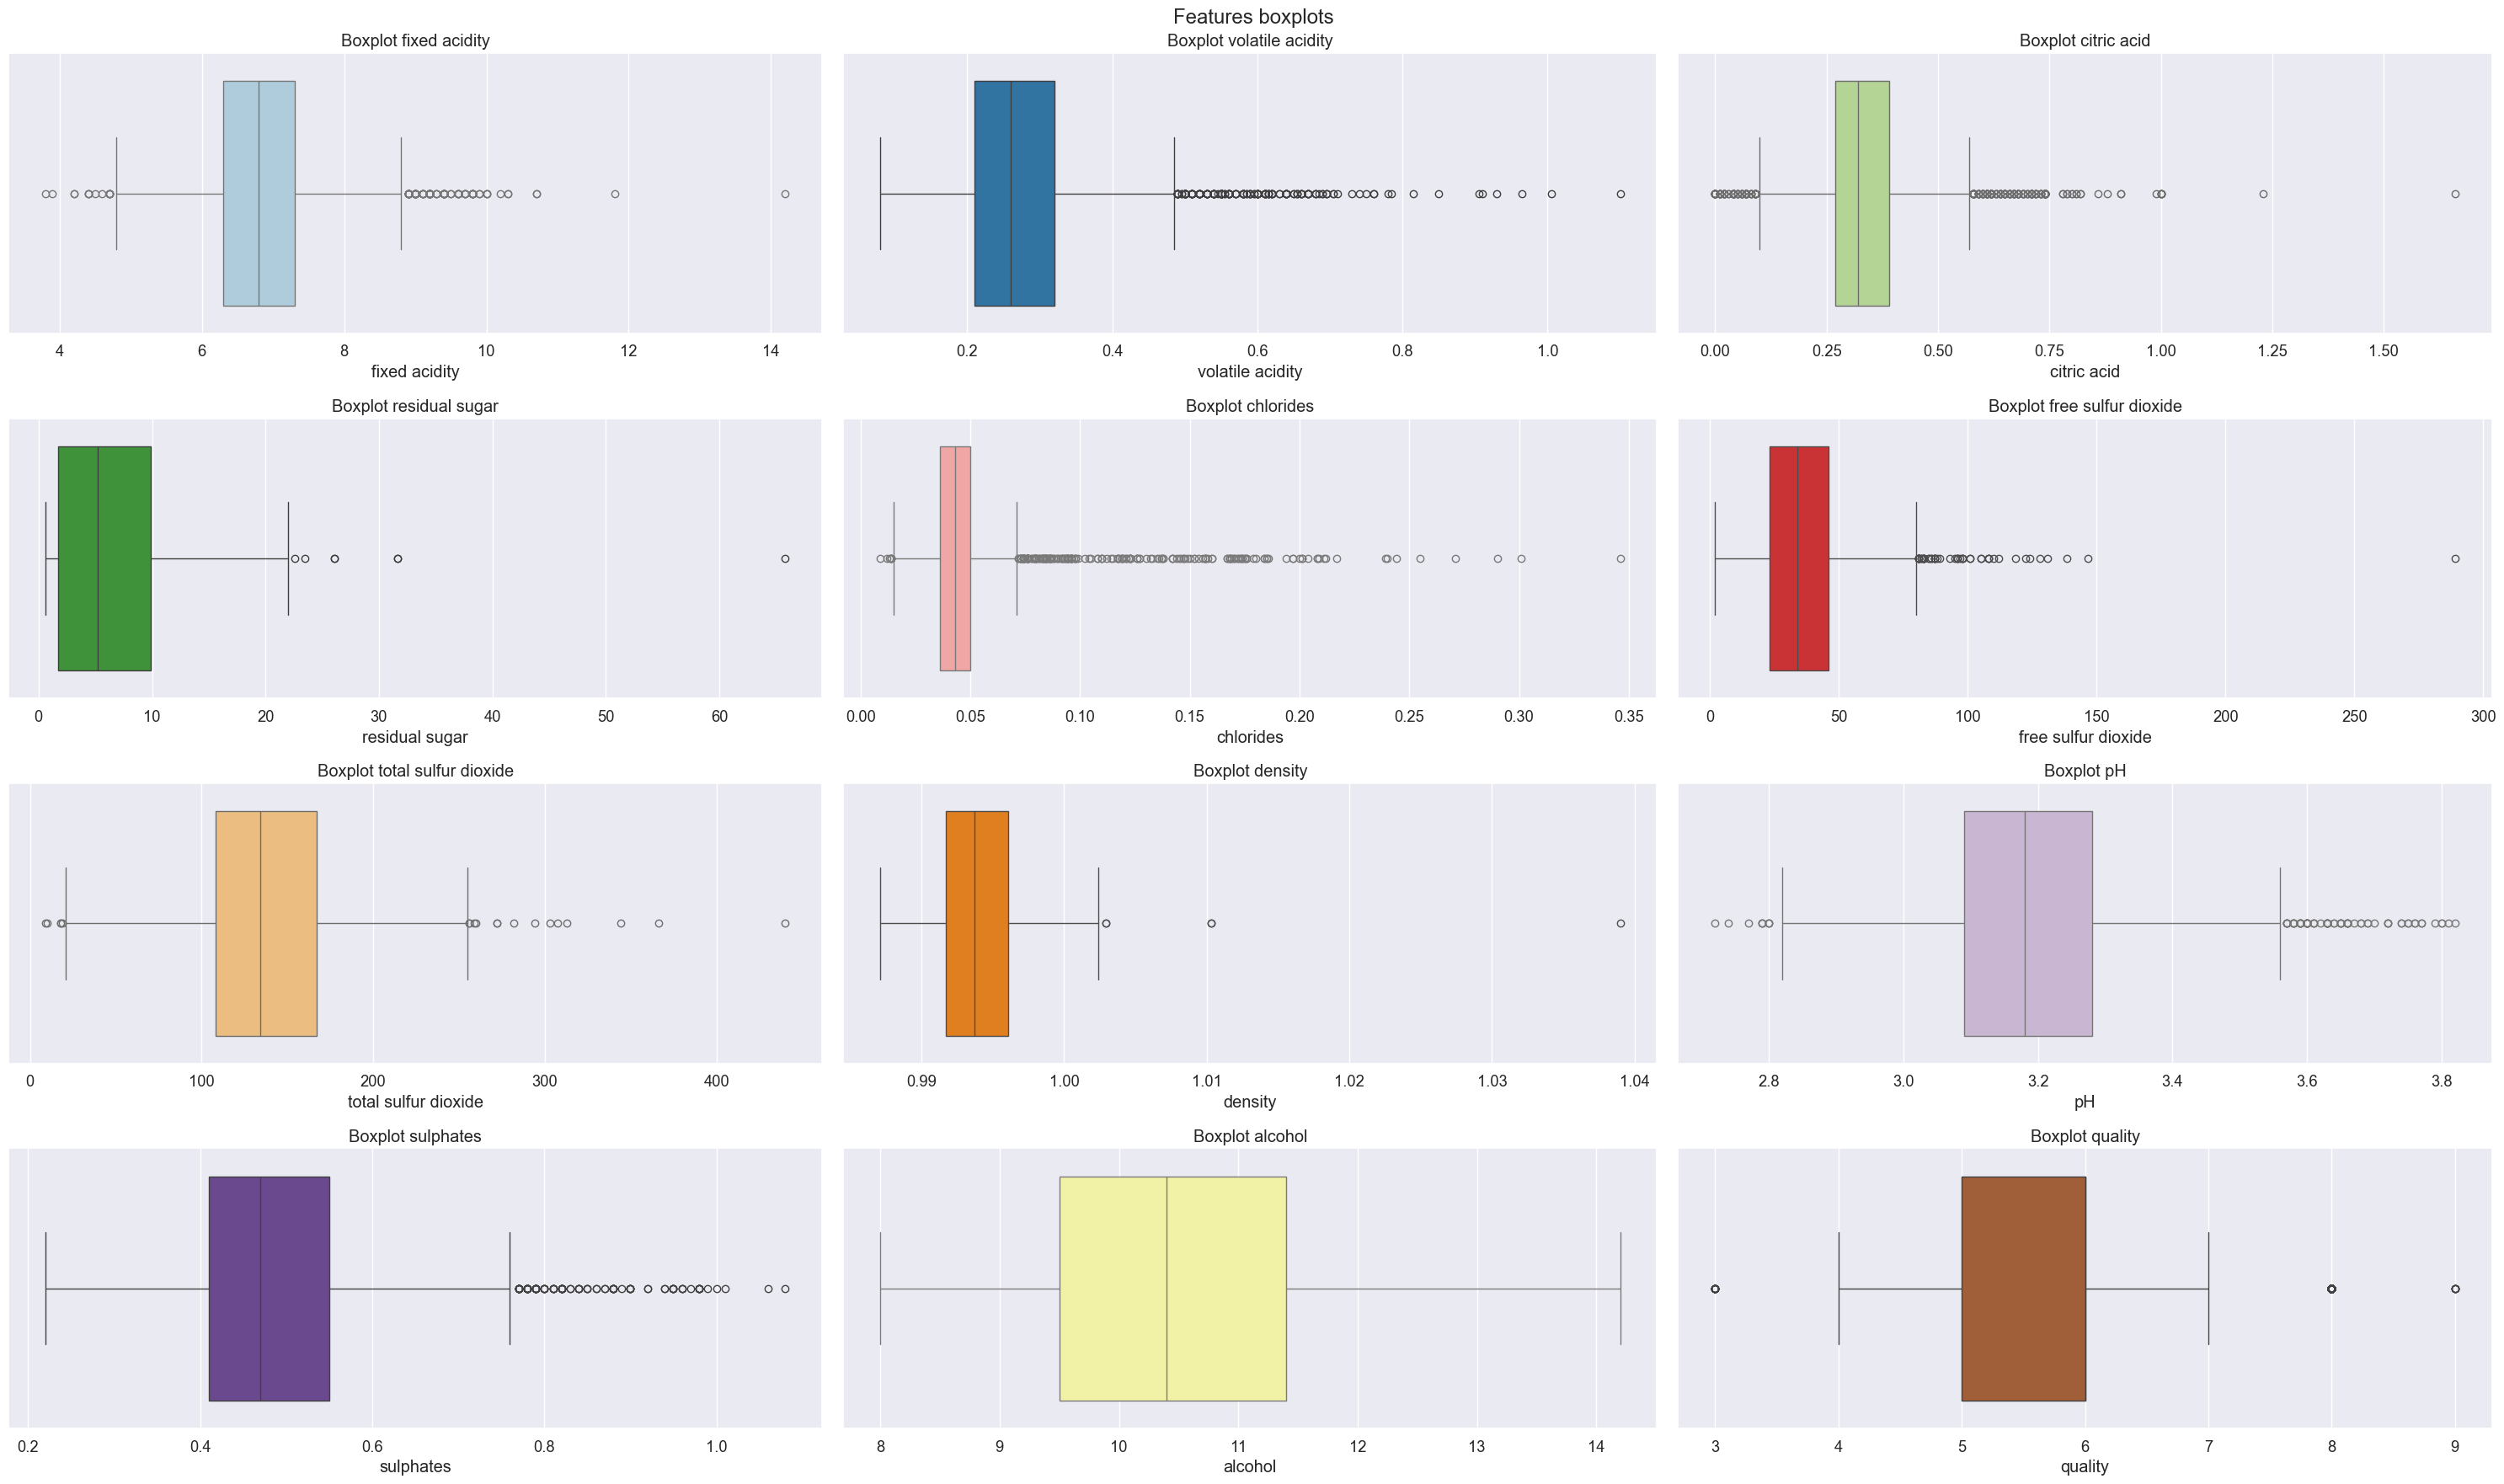

In [18]:
# Visualizando boxplot cada coluna
dataframe_boxplots(white_wine_df, color_dict)

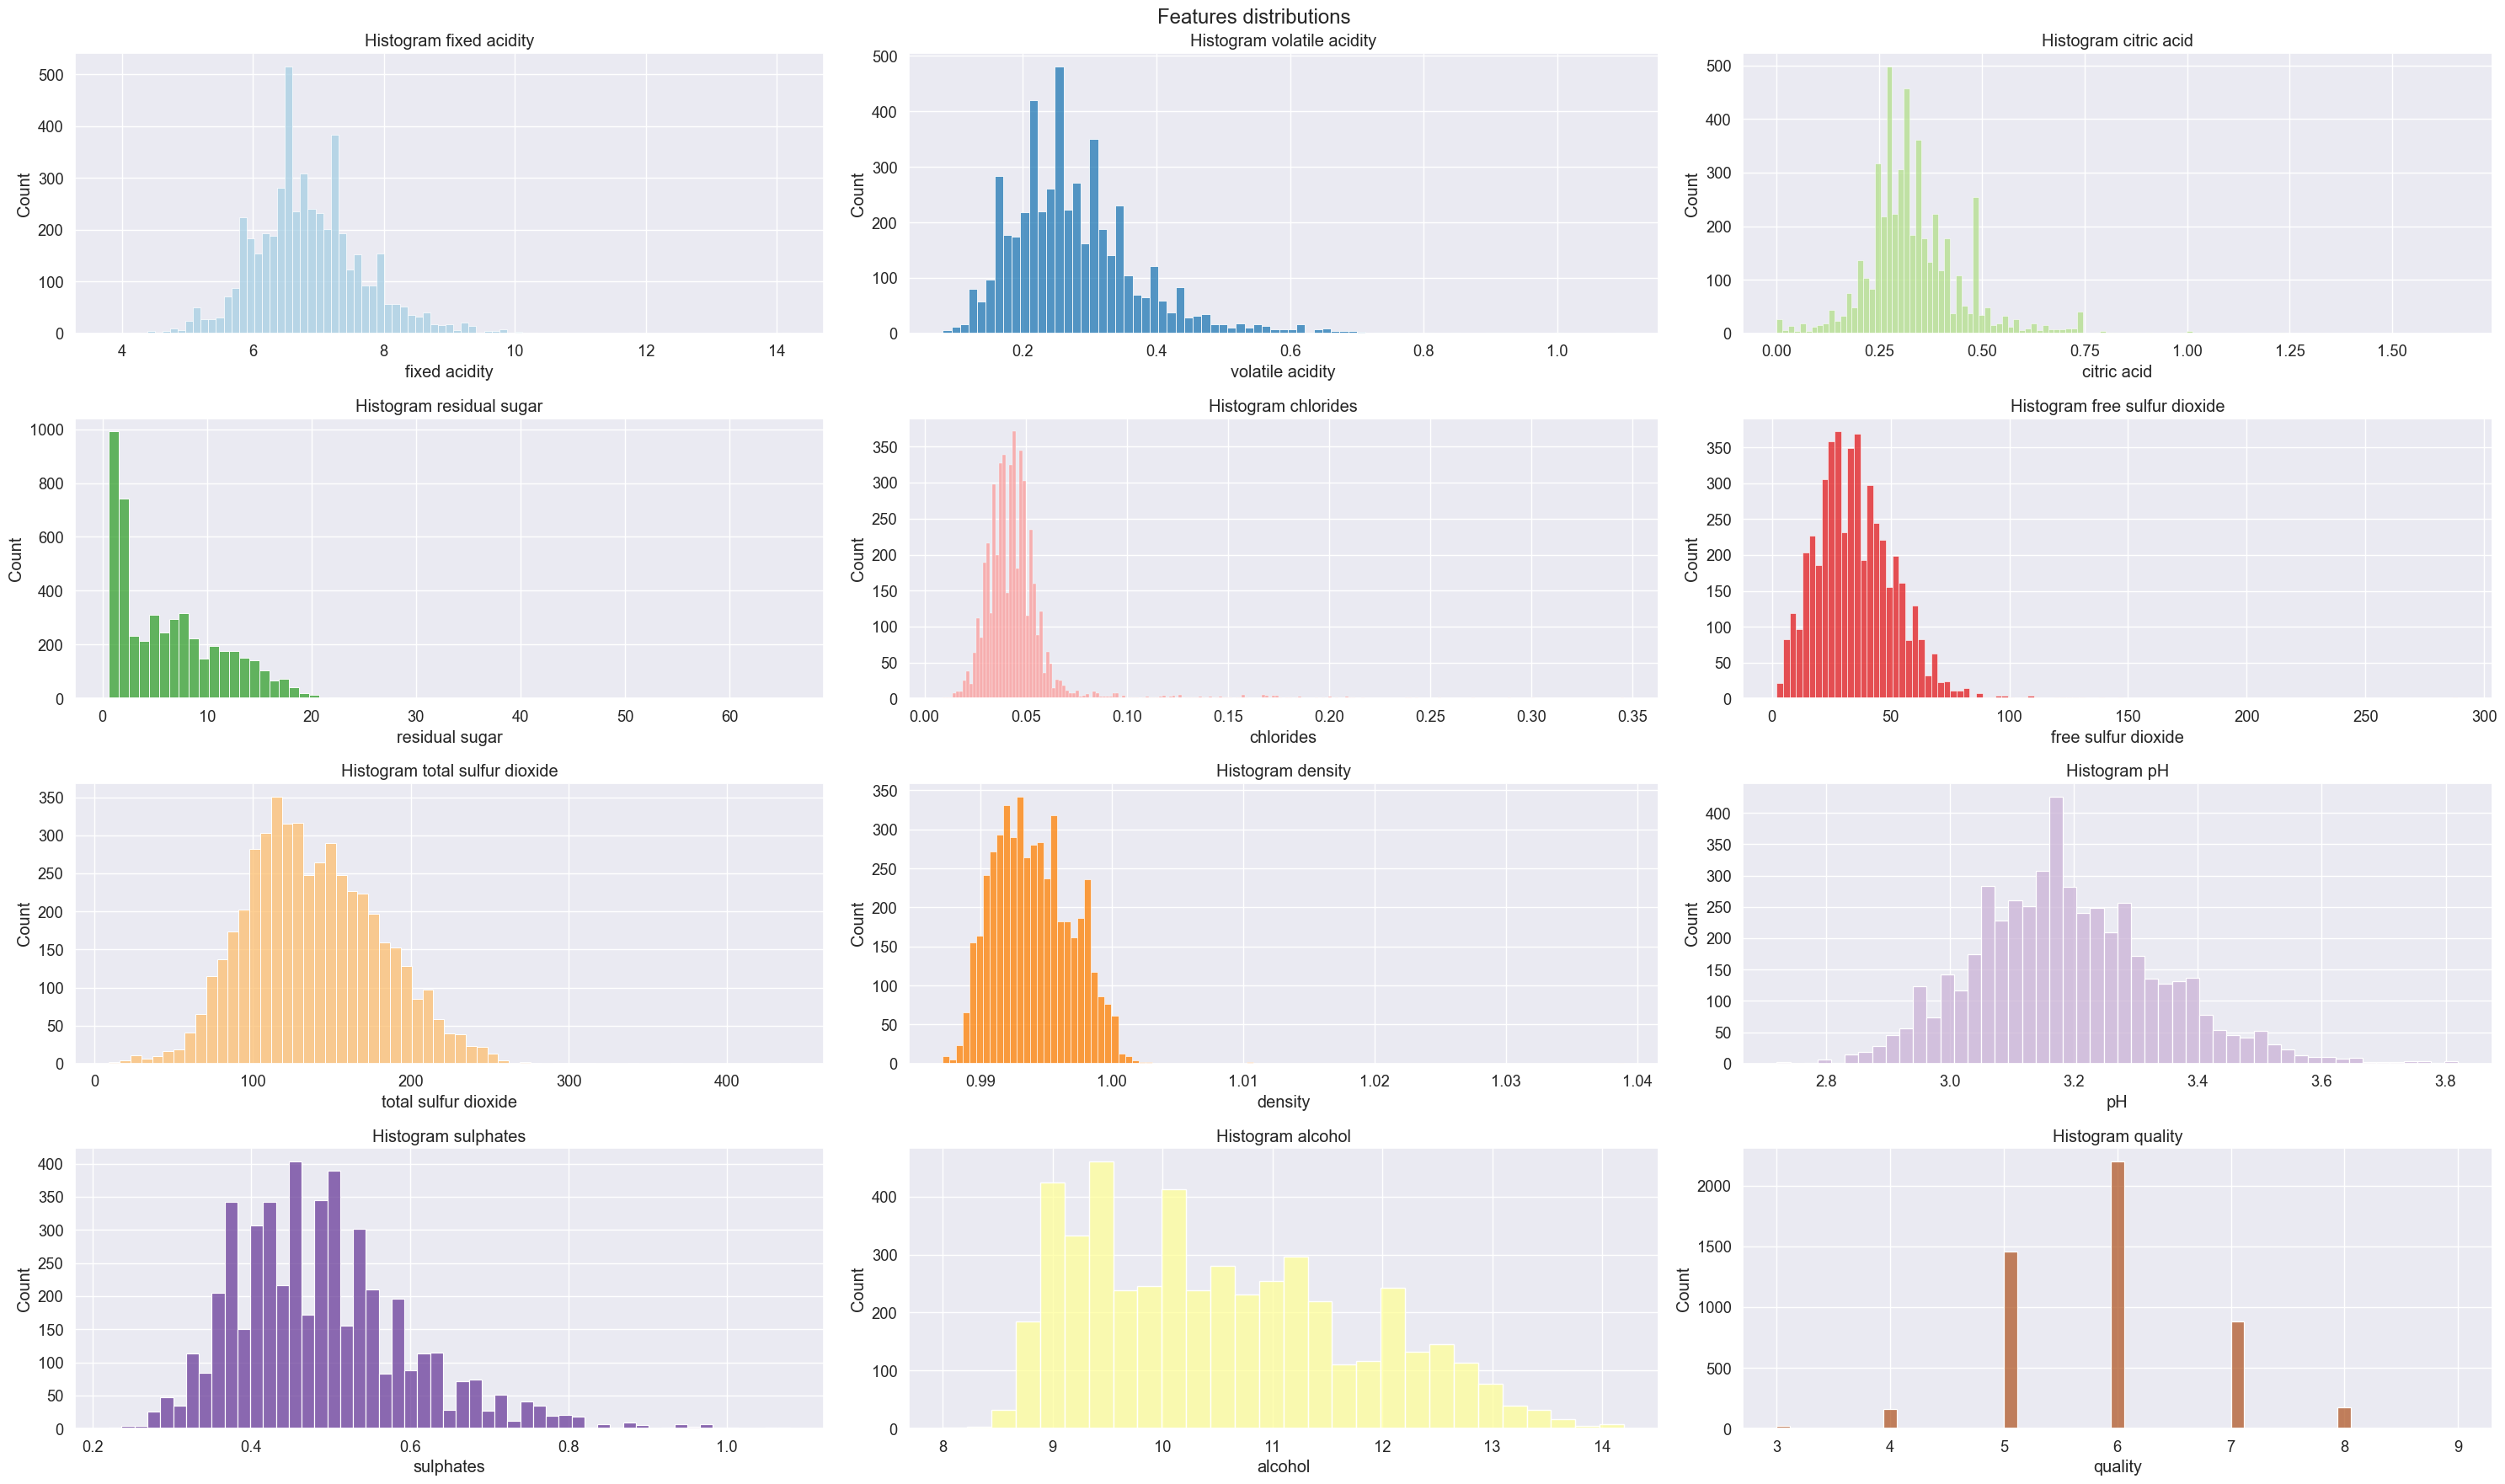

In [19]:
# Visualizando histogramas das colunas
dataframe_histograms(white_wine_df, color_dict)

### Calculando correlação e filtrando colunas


In [20]:
# Calculando correlação entre variáveis
wine_corr_quality = white_wine_df.corr()['quality'].drop('quality')
wine_corr_quality = wine_corr_quality.sort_values()
wine_corr_quality

density                -0.307123
chlorides              -0.209934
volatile acidity       -0.194723
total sulfur dioxide   -0.174737
fixed acidity          -0.113663
residual sugar         -0.097577
citric acid            -0.009209
free sulfur dioxide     0.008158
sulphates               0.053678
pH                      0.099427
alcohol                 0.435575
Name: quality, dtype: float64

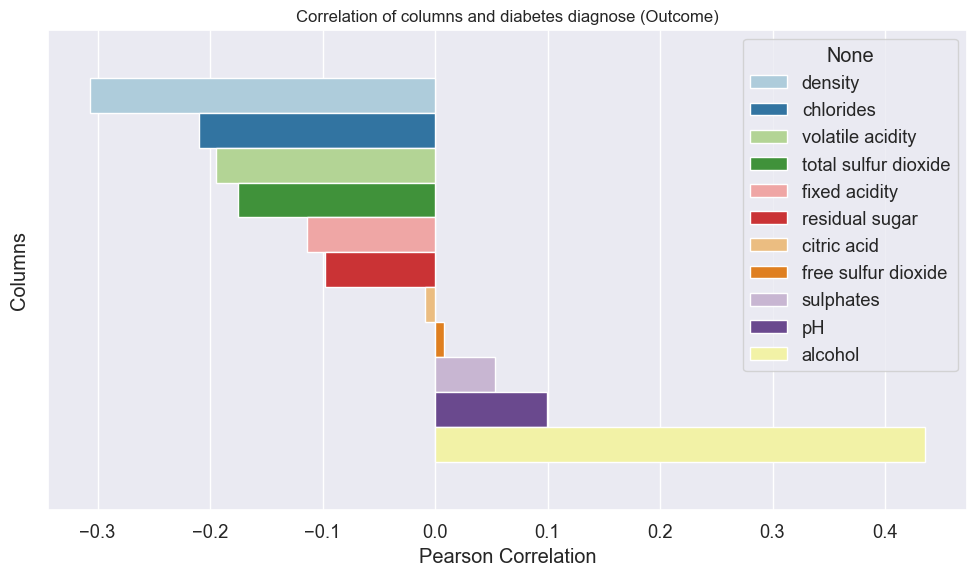

In [21]:
# Visualizando correlações
plot_correlation(wine_corr_quality, color_dict)

As variáveis `citric acid` e`free sulfur dioxide` tem correlação extremamente pequena ($< 0.01$), enquanto a variável `sulphates` tem correlação ~$0.5$. Portanto, essas colunas serão removidas por que são mais responsáveis por introduzir ruido aos dados, do que contribuem para previsão.


In [22]:
wine_df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

### Feature engineering


In [23]:
# Features de interação
wine_df['density_acidity'] = wine_df['density'] * wine_df['fixed acidity']

# Transformações logarítmicas
wine_df['log_chlorides'] = np.log1p(wine_df['chlorides'])

# Features de combinação

wine_df['acidity_ratio'] = wine_df['fixed acidity'] / (
    wine_df['volatile acidity'] + 1e-5
)

In [24]:
# Removendo colunas
wine_df.drop(columns=['citric acid', 'free sulfur dioxide'], inplace=True)

Removendo colunas de baixa influência e chlorides pois a transformação alcança maior correlação.


In [25]:
# Recalculando correlação entre variáveis
wine_corr_quality = wine_df.corr()['quality'].drop('quality')
wine_corr_quality = wine_corr_quality.sort_values()
wine_corr_quality

density                -0.307123
log_chlorides          -0.215960
chlorides              -0.209934
volatile acidity       -0.194723
total sulfur dioxide   -0.174737
density_acidity        -0.120147
fixed acidity          -0.113663
residual sugar         -0.097577
sulphates               0.053678
pH                      0.099427
acidity_ratio           0.144205
alcohol                 0.435575
Name: quality, dtype: float64

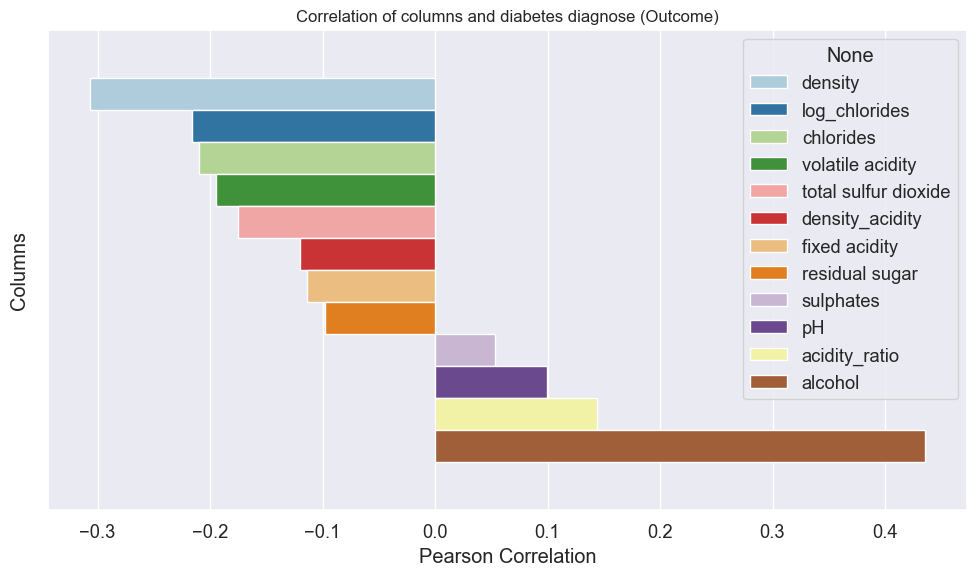

In [26]:
# Visualizando novas correlações
plot_correlation(wine_corr_quality, color_dict)

Remover chlorides (performou melhor a transformação)


### Separando dados


In [27]:
# Separando dados em treino e teste
X = white_wine_df.drop('quality', axis=1)
y = white_wine_df['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Modelagem


### Modelagem simples


In [28]:
# Definindo Pipeline
xgb_model = xgboost_pipeline()
xgb_model.fit(X_train, y_train)
xgb_model.score(X_test, y_test)

0.4841480255126953

In [29]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
rf_model.score(X_test, y_test)

0.5361153416803774

### Modelagem com GridSearchCV


In [30]:
# Criando grids de parâmetros
xgb_param_grid = {
    'model__n_estimators': [100, 300, 500],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [6, 8, 10],
    'model__min_child_weight': [1, 5, 10],
    'model__subsample': [0.7, 0.8, 1.0],
    'model__colsample_bytree': [0.7, 0.8, 1.0],
    'model__gamma': [0, 0.1, 0.3],
    'model__reg_alpha': [0, 0.1, 1],
    'model__reg_lambda': [1, 5, 10],
}

rf_param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
}

In [31]:
xgb = xgboost_pipeline()
xgb_rs_model = RandomizedSearchCV(
    xgb, xgb_param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=2
)
xgb_rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END model__colsample_bytree=0.7, model__gamma=0.1, model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=5, model__n_estimators=100, model__reg_alpha=0, model__reg_lambda=10, model__subsample=0.8; total time=   0.1s
[CV] END model__colsample_bytree=0.7, model__gamma=0.1, model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=5, model__n_estimators=100, model__reg_alpha=0, model__reg_lambda=10, model__subsample=0.8; total time=   0.1s
[CV] END model__colsample_bytree=0.7, model__gamma=0.1, model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=5, model__n_estimators=100, model__reg_alpha=0, model__reg_lambda=10, model__subsample=0.8; total time=   0.1s
[CV] END model__colsample_bytree=0.7, model__gamma=0.1, model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=5, model__n_estimators=100, model__reg_alpha=0, model__reg_lambda=10, model__subsample=0.8; total 

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('model',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           callbacks=None,
                                                           colsample_bylevel=None,
                                                           colsample_bynode=None,
                                                           colsample_bytree=None,
                                                           device=None,
                                                           early_stopping_rounds=None,
                                                           enable_categorical=False,
                                                           eval_metric=None,
                                                           feature_types=None,
                                                           feature_weights=None,
                                                           gamma=None,
                                                           grow_po...
                   n_jobs=-1,
                   param_distributions={'model__colsample_bytree': [0.7, 0.8,
                                                                    1.0],
                                        'model__gamma': [0, 0.1, 0.3],
                                        'model__learning_rate': [0.01, 0.05,
                                                                 0.1],
                                        'model__max_depth': [6, 8, 10],
                                        'model__min_child_weight': [1, 5, 10],
                                        'model__n_estimators': [100, 300, 500],
                                        'model__reg_alpha': [0, 0.1, 1],
                                        'model__reg_lambda': [1, 5, 10],
                                        'model__subsample': [0.7, 0.8, 1.0]},
                   scoring='r2', verbose=2)

In [32]:
rf = RandomForestRegressor()
rf_rs_model = RandomizedSearchCV(
    rf, rf_param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=2
)
rf_rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   1.0s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=3

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 15, 20, None],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 300, 500]},
                   scoring='r2', verbose=2)

## Avaliando performance


In [33]:
print(f'Best Score: {rf_rs_model.best_score_}')
rf_rs_model.best_estimator_

Best Score: 0.5220017766513144


RandomForestRegressor(bootstrap=False, max_features='sqrt', min_samples_split=5,
                      n_estimators=300)

In [34]:
print(f'Best Score: {xgb_rs_model.best_score_ * 100}')
xgb_rs_model.best_estimator_

Best Score: 49.797362089157104


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.8, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, feature_weights=None,
                              gamma=0.1, grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=10, max_leaves=None, min_child_weight=1,
                              missing=nan, monotone_constraints=None,
                              multi_strategy=None, n_estimators=300,
                              n_jobs=None, num_parallel_tree=None, ...))])

In [35]:
# Prevendo valores
xgb_y_pred = xgb_rs_model.predict(X_test)
rf_y_pred = rf_rs_model.predict(X_test)

In [36]:
# Verificando RMSE dos modelos
rmse_rf_rs = root_mean_squared_error(y_pred=rf_y_pred, y_true=y_test)
rmse_xgb_rs = root_mean_squared_error(y_pred=xgb_y_pred, y_true=y_test)

In [37]:
rmse_rf_rs, rmse_xgb_rs

(0.591570857181019, 0.6073802709579468)